In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('fivethirtyeight')

In [2]:
sys.path.append("..") 

from api.utilies import plotstats as ps

In [51]:
color_pal = ['#F8766D', '#D39200', '#93AA00', '#00BA38', '#00C19F', '#00B9E3', '#619CFF', '#DB72FB']

machine_types = ['ДУОМАТИК09-32GSM', 'РПБ-01', 'ЩОМ-1200М', 'ПМГ']
start_date = '2020-04-01'

In [58]:
data = pd.read_csv('../api/tmp/cashes/data/data_m.csv')

In [59]:
ds = {}
for m_type in machine_types:
    print(m_type)
    ds[m_type] = data[(data.machine_type == m_type) & (data.date > start_date)]

ДУОМАТИК09-32GSM
РПБ-01
ЩОМ-1200М
ПМГ


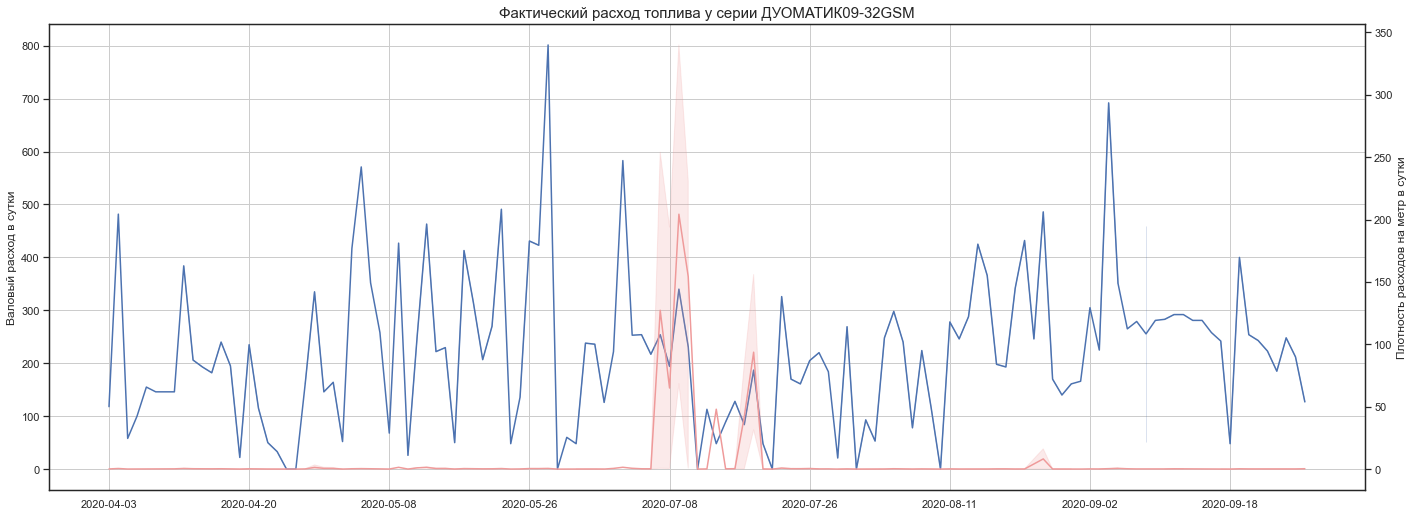

In [54]:
#f_ = data.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
ps.plot_rate_fact(ds['ДУОМАТИК09-32GSM'], 'ДУОМАТИК09-32GSM', '2020-04-01')

In [60]:
for key in ds:
    ds[key]['date'] = pd.to_datetime(ds[key]['date'])
    ds[key] = ds[key].set_index('date')
    ds[key] = ds[key][['rate_fact']]

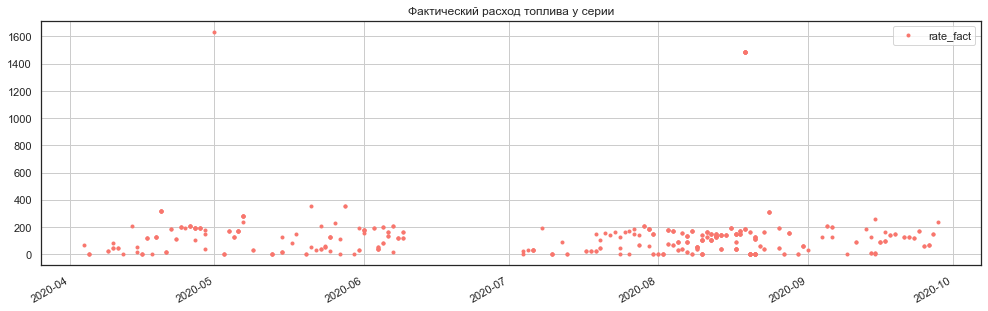

In [66]:
_ = 
.plot(style='.', figsize=(15,5), color=color_pal[0], title='Фактический расход топлива y серии', grid=True, xlabel='')

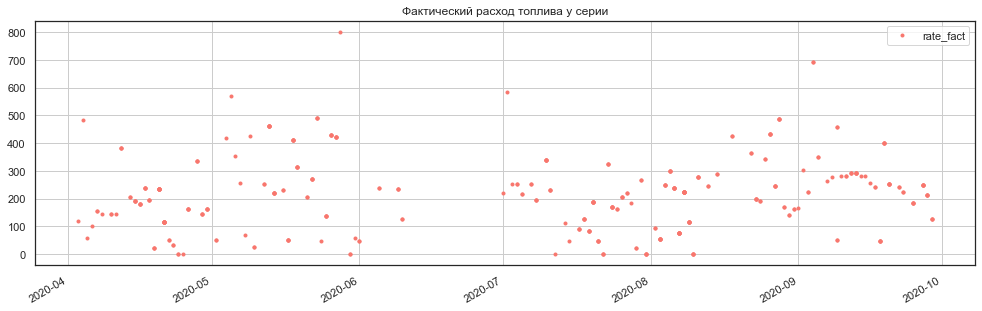

In [67]:
_ = ds['ДУОМАТИК09-32GSM'].plot(style='.', figsize=(15,5), color=color_pal[0], title='Фактический расход топлива y серии', grid=True, xlabel='')

In [74]:
split_date = '2020-08-01'
train_test = {}
for key in ds:
    train_test[key] = []
    train_test[key].append(ds[key].loc[ds[key].index <= split_date].copy())
    train_test[key].append(ds[key].loc[ds[key].index > split_date].copy())

In [77]:
print(train_test['ДУОМАТИК09-32GSM'][0].shape, train_test['ДУОМАТИК09-32GSM'][1].shape)

(216, 1) (151, 1)


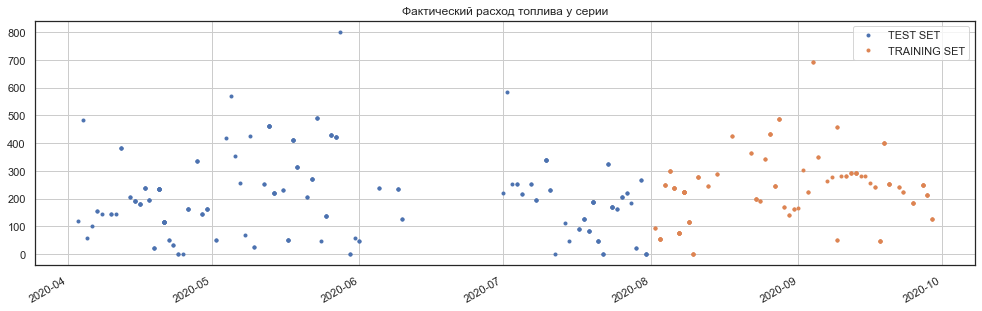

In [80]:
_ = train_test['ДУОМАТИК09-32GSM'][0] \
    .rename(columns={'rate_fact': 'TEST SET'}) \
    .join(train_test['ДУОМАТИК09-32GSM'][1].rename(columns={'rate_fact': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Фактический расход топлива y серии', style='.', grid=True, xlabel='')

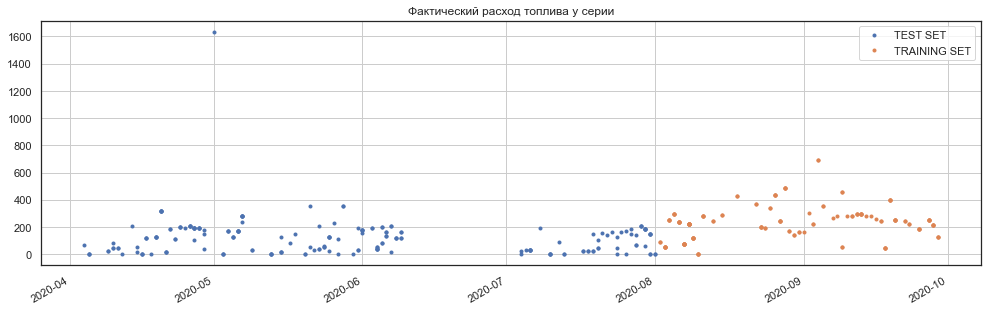

In [81]:
_ = train_test['РПБ-01'][0] \
    .rename(columns={'rate_fact': 'TEST SET'}) \
    .join(train_test['ДУОМАТИК09-32GSM'][1].rename(columns={'rate_fact': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Фактический расход топлива y серии', style='.', grid=True, xlabel='')

In [82]:
def create_features(df, label=None):

    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [83]:
prep_2learn = {}
for key in train_test:
    X_train, y_train = create_features(train_test[key][0], label='rate_fact')
    X_test, y_test = create_features(train_test[key][1], label='rate_fact')

    train = {'X': X_train, 'y': y_train}
    test = {'X': X_test, 'y': y_test}

    prep_2learn[key] = []
    prep_2learn[key].append(train)
    prep_2learn[key].append(test)

In [89]:
models = {}

for key in prep_2learn:
    X_train = prep_2learn[key][0]['X']
    y_train = prep_2learn[key][0]['y']

    X_test = prep_2learn[key][1]['X']
    y_test = prep_2learn[key][1]['y']

    reg = xgb.XGBRegressor(n_estimators=1000)
    _ = reg.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    early_stopping_rounds=50,
                verbose=False)

    models[key] = reg

In [90]:
models

{'ДУОМАТИК09-32GSM': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
 'РПБ-01': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000

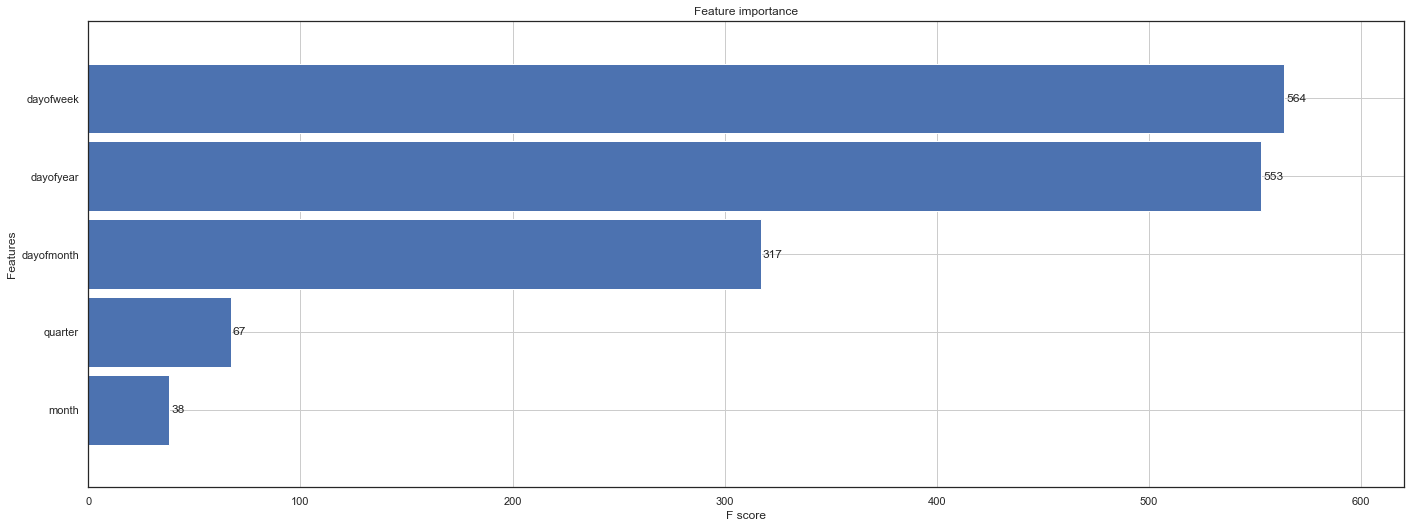

In [91]:
_ = plot_importance(models['ДУОМАТИК09-32GSM'], height=0.9)

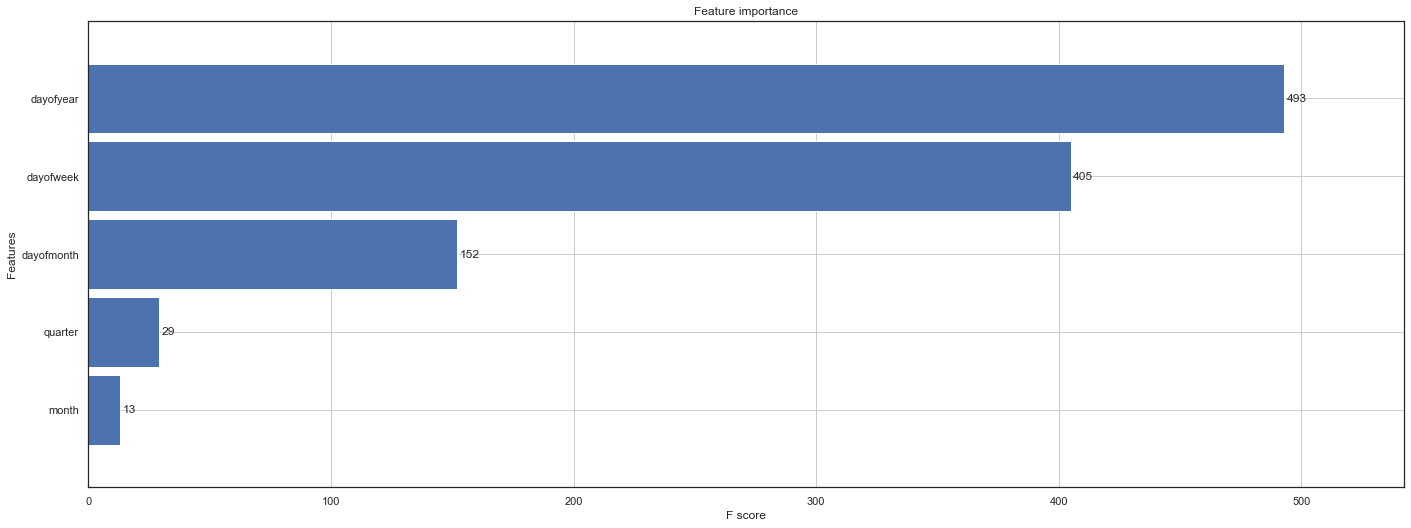

In [92]:
_ = plot_importance(models['ЩОМ-1200М'], height=0.9)

In [95]:
alls = {}

for key in prep_2learn:
    X_test = prep_2learn[key][1]['X']
    y_test = prep_2learn[key][1]['y']
    train_test[key][1]['rate_fact_prediction'] = models[key].predict(X_test)

    alls[key] = pd.concat([train_test[key][1], train_test[key][0]], sort=False)

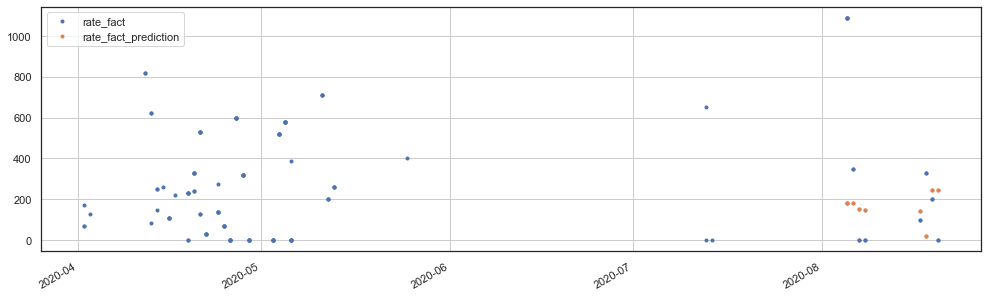

In [97]:
_ = alls['ЩОМ-1200М'][['rate_fact','rate_fact_prediction']].plot(figsize=(15, 5), style='.', grid=True, xlabel='')

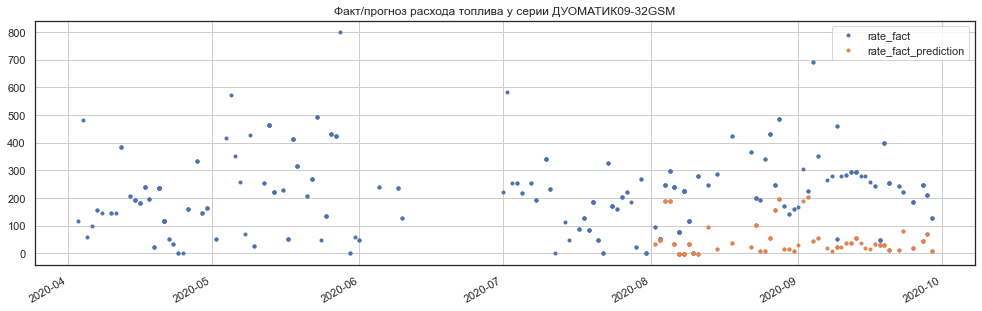

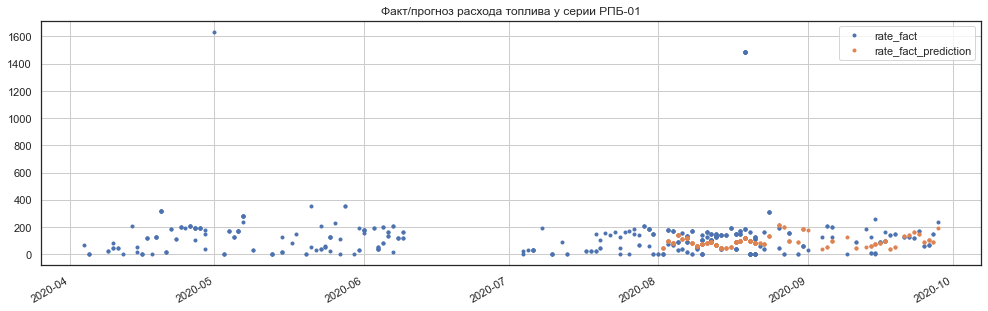

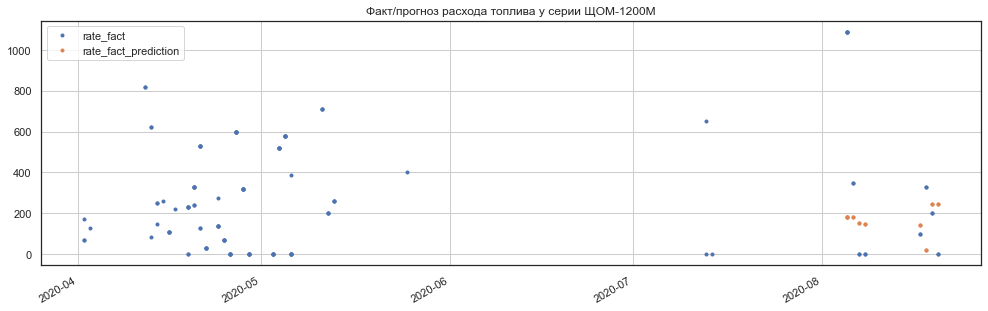

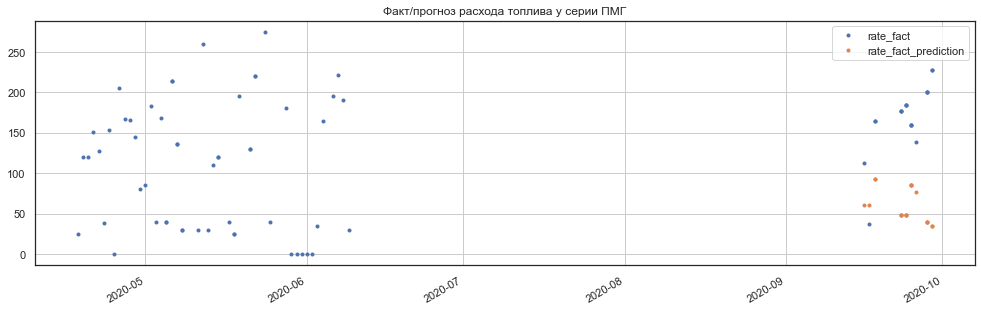

In [101]:
figs = {}
for key in alls:

    figs[key] = alls[key][['rate_fact','rate_fact_prediction']].plot(figsize=(15, 5), style='.', grid=True, xlabel='', title='Факт/прогноз расхода топлива y серии {}'.format(key))